In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Sequential

> **Data preparing**

In [2]:
#building function to help split files to label and text
def process_data(file):
    data = []
    for index, row in file.iterrows():
         # first line data is raw data
        line = row[0]

        #split lines into text and labels
        label, text = line.split(' ', 1)

        #remove the __label__ only keep the number
        label = label.replace('__label__', '')

        #append
        data.append((label, text.strip()))

    cols = ['label', 'review']
    return pd.DataFrame(data, columns=cols)

In [3]:
#build a function for data cleaning
def cleaning(text):
    text = text.lower()

    #remove special characters and numbers and extra whitespace
    pattern_punc = r'[^A-Za-z\s]'
    text = re.sub(pattern_punc, '', text).strip()
    return text

In [4]:
train_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
test_path = '/kaggle/input/amazonreviews/test.ft.txt.bz2'

In [5]:
!pip install bz2file

import bz2
import os

def decompress_bz2(input_file, output_file):
    """Decompresses a bz2 file to a new file.

    Args:
        input_file (str): Path to the bz2 file.
        output_file (str): Path to the output file.
    """
    # using bz2file library for better error handling in case of file corruption
    try:
        with bz2.BZ2File(input_file, 'rb') as f_in:
            with open(output_file, 'wb') as f_out:
                f_out.write(f_in.read())
    except OSError as e:
        print(f"Error decompressing {input_file}: {e}")
         


# Decompress the train and test files
train_path_bz2 = '/kaggle/input/amazonreviews/train.ft.txt.bz2'  # Original bz2 file path
train_path = 'train.ft.txt'  # New uncompressed file path
test_path_bz2 = '/kaggle/input/amazonreviews/test.ft.txt.bz2'  # Original bz2 file path
test_path = 'test.ft.txt'  # New uncompressed file path

decompress_bz2(train_path_bz2, train_path)
decompress_bz2(test_path_bz2, test_path)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for bz2file: filename=bz2file-0.98-py3-none-any.whl size=6868 sha256=aafc236f8612993706bc5c3eb1d55b075295b31e27aab05a27956686c26d9a4f
  Stored in directory: /root/.cache/pip/wheels/69/ee/f7/6fccd10cb65421ba2da64fa6caf8ee7fbae0059884af8c8587
Successfully built bz2file


In [6]:
train_data = pd.read_csv(train_path, delimiter='\t', header=None)
test_data = pd.read_csv(test_path, delimiter='\t', header=None)
print(train_data.head())

                                                   0
0  __label__2 Stuning even for the non-gamer: Thi...
1  __label__2 The best soundtrack ever to anythin...
2  __label__2 Amazing!: This soundtrack is my fav...
3  __label__2 Excellent Soundtrack: I truly like ...
4  __label__2 Remember, Pull Your Jaw Off The Flo...


In [7]:
print("Train data shape" ,train_data.shape)
print("Test data shape" ,test_data.shape)

Train data shape (3600000, 1)
Test data shape (400000, 1)


In [8]:
train = process_data(train_data)
train.head()

,label,review
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


In [9]:
test = process_data(test_data)
test.head()

,label,review
0,2,Great CD: My lovely Pat has one of the GREAT v...
1,2,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...: I bought thi...
3,2,"works fine, but Maha Energy is better: Check o..."
4,2,Great for the non-audiophile: Reviewed quite a...


1 is the negative review while 2 is the positive one so we will replace 2 with 1 and 1 with 0

In [10]:
train['label'].value_counts()

label
2    1800000
1    1800000
Name: count, dtype: int64

**Data Cleaning**

In [11]:
train['label'] = train['label'].replace({"2":"1", "1":"0"}) #train data
test['label'] = test['label'].replace({"2":"1", "1":"0"}) #test data

In [12]:
train['review_cleaned'] = train['review'].apply(cleaning)
train.head()

,label,review,review_cleaned
0,1,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,1,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,1,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


In [13]:
test['review_cleaned'] = test['review'].apply(cleaning)
test.head()

,label,review,review_cleaned
0,1,Great CD: My lovely Pat has one of the GREAT v...,great cd my lovely pat has one of the great vo...
1,1,One of the best game music soundtracks - for a...,one of the best game music soundtracks for a ...
2,0,Batteries died within a year ...: I bought thi...,batteries died within a year i bought this ch...
3,1,"works fine, but Maha Energy is better: Check o...",works fine but maha energy is better check out...
4,1,Great for the non-audiophile: Reviewed quite a...,great for the nonaudiophile reviewed quite a b...


**Toknization and Padding**

In [14]:
 

max_words = 500
max_len = 75

 
tokenizer = Tokenizer(num_words=max_words)

# fit on the entire training data  
tokenizer.fit_on_texts(train['review_cleaned'])



 

In [15]:
#  Define a batch processing function
def process_batch(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences

# 4. Process data in batches
batch_size = 500  
X_train = []
for i in range(0, len(train), batch_size):
    X_train.extend(process_batch(train['review_cleaned'].iloc[i : i + batch_size]))
X_train = np.array(X_train)

X_test = []
for i in range(0, len(test), batch_size):
    X_test.extend(process_batch(test['review_cleaned'].iloc[i : i + batch_size]))
X_test = np.array(X_test)

In [16]:
y_train = train['label']
y_test = test['label']

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
X_train = np.array(X_train)
print("Train:", X_train.shape)
y_train = np.array(y_train)
print("Train:", y_train.shape)
print("-"*50)
X_valid = np.array(X_valid)
print("Valid:", X_valid.shape)
y_valid = np.array(y_valid)
print("Valid:", y_valid.shape)
print("-"*50)
X_test = np.array(X_test)
print("Test:", X_test.shape)
y_test = np.array(y_test)
print("Test:", y_test.shape)

Train: (2880000, 75)
Train: (2880000,)
--------------------------------------------------
Valid: (720000, 75)
Valid: (720000,)
--------------------------------------------------
Test: (400000, 75)
Test: (400000,)


In [19]:
y_train = y_train.astype('int')
y_valid = y_valid.astype('int')
y_test = y_test.astype('int')

**LSTM model building**

In [20]:
model = Sequential()
model.add(Input(shape=(max_words,), dtype='int32'))
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))  
model.add(LSTM(units=256))
model.add(Dense(1,activation='sigmoid'))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 128)       │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,081 (2.25 MB)

 Trainable params: 590,081 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=4096,  
          verbose=1, 
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping])

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 192s 266ms/step - accuracy: 0.8104 - loss: 0.4037 - val_accuracy: 0.8838 - val_loss: 0.2730
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 187s 266ms/step - accuracy: 0.8868 - loss: 0.2661 - val_accuracy: 0.8934 - val_loss: 0.2517
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 187s 266ms/step - accuracy: 0.8973 - loss: 0.2454 - val_accuracy: 0.9022 - val_loss: 0.2352
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 188s 266ms/step - accuracy: 0.9039 - loss: 0.2318 - val_accuracy: 0.9063 - val_loss: 0.2260
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 188s 267ms/step - accuracy: 0.9082 - loss: 0.2232 - val_accuracy: 0.9055 - val_loss: 0.2305
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 187s 266ms/step - accuracy: 0.9112 - loss: 0.2169 - val_accuracy: 0.9128 - val_loss: 0.2130
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 188s 266ms/step - accuracy: 0.9138 - loss: 0.2109 - val_accuracy: 0.9143 - val_loss: 0.2103
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 187s 266ms/step - accuracy: 0.9168 -

In [22]:
loss, acc = model.evaluate(X_valid, y_valid)
print("Validation Loss = ", loss)
print("Validation Accuracy = ", acc*100, "%")

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - accuracy: 0.9180 - loss: 0.2022
Validation Loss =  0.2026911824941635
Validation Accuracy =  91.77333116531372 %


In [23]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Loss = ", loss)
print("Test Accuracy = ", acc*100, "%")

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - accuracy: 0.9147 - loss: 0.2085
Test Loss =  0.20365293323993683
Test Accuracy =  91.6902482509613 %


In [24]:
preds = model.predict(X_test)

threshold = 0.5
pred_labels = (preds >= threshold)
true_labels = y_test

cr = classification_report(true_labels, pred_labels)
print(cr)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.92    200000
           1       0.92      0.91      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



array([[184915,  15085],
       [ 18154, 181846]])

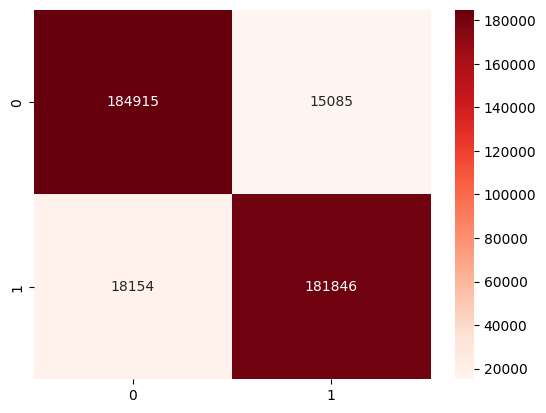

In [25]:
import seaborn as sns
CM = confusion_matrix(y_test, pred_labels)
sns.heatmap(CM, annot = True,fmt='g', cmap='Reds')
CM

In [26]:
model.save('my_amazon_review_model.h5')